In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import clip  # For text encoding

In [2]:
import numpy as np
text_descriptions = [
    "A cat jumping over a fence.",
    "A dog playing with a ball in the park.",
    "A person sitting at a desk working on a laptop.",
    "A car driving down a road during sunset.",
    "A group of people walking down the street.",
    "A child playing with a toy in the living room.",
    "A beautiful mountain landscape during sunrise.",
    "A person cooking food in the kitchen.",
    "A group of birds flying in the sky."
]

# Initialize CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Random text feature generator (choose one text description randomly)
def generate_random_text_feature(batch_size):
    """
    Generate random text features for the given batch size.
    
    Args:
        batch_size (int): The number of random text features to generate.
        text_size (int): The size of each text feature (e.g., embedding size).
    
    Returns:
        torch.Tensor: Random text features of shape (batch_size, text_size).
    """
    # Randomly choose a description for each image in the batch
    random_descriptions = np.random.choice(text_descriptions, size=batch_size)
    
    # Tokenize and encode text descriptions using CLIP
    text_input = clip.tokenize(random_descriptions).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_input)  # Shape: (batch_size, text_size)
    
    return text_features,random_descriptions

In [3]:
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4):
        super(LoRALayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        
        # Original weight matrix (frozen)
        self.W_0 = nn.Parameter(torch.randn(out_features, in_features))
        # Low-rank matrices A and B
        self.A = nn.Parameter(torch.randn(out_features, rank))
        self.B = nn.Parameter(torch.randn(rank, in_features))
        
        # Initialize weights
        nn.init.kaiming_normal_(self.W_0)
        nn.init.kaiming_normal_(self.A)
        nn.init.kaiming_normal_(self.B)

    def forward(self, x):
        # Perform the LoRA adjustment
        weight = self.W_0 + torch.matmul(self.A, self.B)
        return F.linear(x, weight)

In [4]:
class ImageTextToVideoGenerator(nn.Module):
    def __init__(self, image_size=32, text_size=512, rank=4):
        super(ImageTextToVideoGenerator, self).__init__()
        
        self.image_size = image_size
        self.text_size = text_size
        
        # Total input size should be image_size * image_size * 3 (for RGB) + text_size
        self.input_size = image_size * image_size * 3 + text_size

        # LoRA layers for predicting next and previous frames
        self.lora_fc1_next = LoRALayer(self.input_size, 512,rank=rank)
        self.lora_fc2_next = LoRALayer(512, 256,rank=rank)
        self.lora_fc3_next = LoRALayer(256, 128,rank=rank)
        
        self.lora_fc1_prev = LoRALayer(self.input_size, 512,rank=rank)
        self.lora_fc2_prev = LoRALayer(512, 256,rank=rank)
        self.lora_fc3_prev = LoRALayer(256, 128,rank=rank)

        # Final output layers for next and previous frame predictions
        self.fc_out_next = nn.Linear(128, 3 * image_size * image_size)  # Output image (next frame)
        self.fc_out_prev = nn.Linear(128, 3 * image_size * image_size)  # Output image (previous frame)

    def forward(self, image_features, text_features):
    # Flatten the image features
        image_features = image_features.view(image_features.size(0), -1)  # Flatten to (batch_size, 3*32*32)

        # Make sure text_features is a 2D tensor
        text_features = text_features.view(text_features.size(0), -1)  # Ensure it's (batch_size, text_size)
        # Combine image and text features
        combined_features = torch.cat([image_features, text_features], dim=1)  # Shape: (batch_size, 3200)

        # First layer for next frame
        x_next = F.relu(self.lora_fc1_next(combined_features))  # Shape: (batch_size, 512)
        x_next = F.relu(self.lora_fc2_next(x_next))  # Shape: (batch_size, 256)
        x_next = F.relu(self.lora_fc3_next(x_next))  # Shape: (batch_size, 128)

        # First layer for previous frame
        x_prev = F.relu(self.lora_fc1_prev(combined_features))  # Shape: (batch_size, 512)
        x_prev = F.relu(self.lora_fc2_prev(x_prev))  # Shape: (batch_size, 256)
        x_prev = F.relu(self.lora_fc3_prev(x_prev))  # Shape: (batch_size, 128)

        # Output video frames (flattened)
        output_frame_prev = self.fc_out_prev(x_prev)  # Shape: (batch_size, 3 * 32 * 32)
        output_frame_prev = output_frame_prev.view(-1, 3, self.image_size, self.image_size)  # Reshape to (batch_size, 3, 32, 32)

        output_frame_next = self.fc_out_next(x_next)  # Shape: (batch_size, 3 * 32 * 32)
        output_frame_next = output_frame_next.view(-1, 3, self.image_size, self.image_size)  # Reshape to (batch_size, 3, 32, 32)

        return output_frame_prev, output_frame_next


In [49]:
def train(model, dataloader, epochs=10, lr=1e-3, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for i, (images, label) in enumerate(dataloader):
            images= images.to(device)
            text_features,_ = generate_random_text_feature(images.size(0)).to(device)
            optimizer.zero_grad()

            # Forward pass: predict previous and next frames
            pred_prev, pred_next = model(images, text_features)
            _, prev_next = model(pred_prev, text_features)
            next_prev, _ = model(pred_next, text_features)
            # Calculate loss between predicted frames and the real frames
            loss = F.mse_loss(next_prev, images) + F.mse_loss(prev_next, images)
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader)}")
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the generator model
model = ImageTextToVideoGenerator().to(device)

# Train the model

# Initialize CIFAR-10 dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize the model and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"

train(model, train_dataloader, epochs=10)

Epoch [1/10], Loss: 0.8849543142570415
Epoch [2/10], Loss: 0.5083020650188814
Epoch [3/10], Loss: 0.4722380752908215
Epoch [4/10], Loss: 0.4501917041690397
Epoch [5/10], Loss: 0.4406351975271966
Epoch [6/10], Loss: 72.88154170515823
Epoch [7/10], Loss: 0.5392954900946589
Epoch [8/10], Loss: 0.5387999266290695
Epoch [9/10], Loss: 0.537877062155662
Epoch [10/10], Loss: 0.5359363305172093


In [62]:
import cv2
import numpy as np
import torch

def save_video(frames, filename="generated_video.mp4", fps=30):
    """
    Save a sequence of frames as a video.
    
    Args:
        frames (list): List of frames (numpy arrays) to be saved as video.
        filename (str): The output video filename.
        fps (int): Frames per second in the video.
    """
    height, width, _ = frames[0].shape  # Get frame size
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in frames:
        # Ensure frame is uint8 (0-255) before writing
        frame = np.clip(frame, 0, 255).astype(np.uint8)
        out.write(frame)

    out.release()



In [76]:
import matplotlib.pyplot as plt
def generate_video(model, dataloader, device, num_frames=10):
    """
    Generate a video by iteratively creating multiple frames starting from a single image.
    
    Args:
        model: The trained model to generate frames.
        dataloader: DataLoader with input images and text features.
        device: Device to run the model (e.g., "cuda" or "cpu").
        num_frames (int): Number of frames to generate for the video.
    
    Returns:
        List of generated frames.
    """
    model.eval()
    frames = []
    
    # Get a single image from the dataloader
    images, _ = next(iter(dataloader))
    plt.imshow(((images[0]+1)/2).permute(1, 2, 0))
    plt.axis("off")  # Hide axis for better visualization
    plt.show()
    image = images[0].unsqueeze(0).to(device)  # Take the first image and keep batch dim

    # Generate a random text feature for this video
    text_features, text_description = generate_random_text_feature(1)  # 1 text feature
    print("Text Description:", text_description)
    
    # Start with the original image as the first frame
    frames.append(image.cpu().numpy().squeeze().transpose(1, 2, 0))  # Convert to (H, W, C)

    # Iteratively generate frames
    with torch.no_grad():
        for _ in range(num_frames - 1):
            # Generate next frame using the model
            generated_frame, _ = model(image.view(image.size(0), -1), text_features.to(device))
            
            # Prepare next frame for generation
            image = generated_frame.view(1, 3, 32, 32)  # Reshape if needed (adjust based on your image size)
            
            # Convert generated frame to numpy for visualization
            generated_frame_np = generated_frame.cpu().numpy().squeeze().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
            generated_frame_np = (generated_frame_np + 1) / 2
            # Ensure the pixel values are in range [0, 255] and dtype is uint8
            generated_frame_np = np.clip(generated_frame_np * 255, 0, 255).astype(np.uint8)

            
            frames.append(generated_frame_np)

    return frames


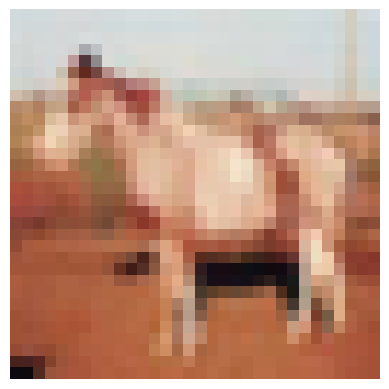

Text Description: ['A cat jumping over a fence.']


In [77]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate a video with 10 frames using the dataloader
frames = generate_video(model, train_dataloader, device, num_frames=80)

# Save the generated frames as a video
save_video(frames, "outputs/generated_video.mp4", fps=30)